# Optimal design parameters

Problem: find the optimal design parameters for a SDM that meets the following requirements:
    - Target SNR: 90 dB
    - Bandwidth: 20 kHz

To achieve this, we will use **brute-force search** through different parameter combinations, and identify the best configuration that maximizes SNR, while keeping design complexity manageable.

We will vary the following parameters to determine the best configuration:
    - Modulator order: between 2 and 6
    - Oversampling ratio: range 16 to 256
    - Number of DAC levels: 2 or 3
    - Hinf gain: between 1.0 and 2.5

We will iterate through all possible combinations of these parameters and run SNR simulations for each case. The best configuration will be the one that achieves at least 90 dB SNR with the lowest complexity (for instance, lower order and OSR if multiple options).

In [1]:
%pip install git+https://github.com/hammal/cbadc.git@feature/0.4.0

# import necessary libraries:
import numpy as np
import cbadc as cb
import matplotlib.pyplot as plt
from itertools import product

  Cloning https://github.com/hammal/cbadc.git (to revision feature/0.4.0) to c:\users\frang\appdata\local\temp\pip-req-build-51od8y43
  Resolved https://github.com/hammal/cbadc.git to commit e5cc310faf08525bd7238c6bb4dcc5bb4c37540e
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached deltasigma-0.2.6-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/hammal/cbadc.git 'C:\Users\frang\AppData\Local\Temp\pip-req-build-51od8y43'
  Running command git checkout -b feature/0.4.0 --track origin/feature/0.4.0
  branch 'feature/0.4.0' set up to track 'origin/feature/0.4.0'.
  Switched to a new branch 'feature/0.4.0'

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\frang\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## First approach

In [2]:
# target specifications:
target_SNR = 90
Bw = 20e3

In [3]:
# parameter search space:
orders = [2, 3, 4, 5, 6] # modulator order
osr_values = [16, 32, 64, 128, 256] # oversampling ratio
nlev_values = [2, 3] # number of DAC levels
Hinf_values = [1.0, 1.5, 2.0, 2.5] # feedback gain

tdac = [0, 1] # DAC sampling times
form = "FB" # modulator architecture (feedback)

In [4]:
# store results:
best_config = None
best_snr = 0
all_results = []

In [5]:
# brute-force search:
for order, osr, nlev, Hinf in product(orders, osr_values, nlev_values, Hinf_values):
    # compute the sampling frequency:
    fs = Bw * osr * 2
    print(f"Sampling frequency: {fs / 1e6} MHz")
    
    print("###################################")
    print(f"Testing: order={order}, osr={osr}, nlev={nlev}, Hinf={Hinf}")
    print("###################################")
    
    # synthesize the Noise Transfer Function (NTF):
    ntf = cb.delsig.synthesizeNTF(order, osr, 2, Hinf, 0.0)
    
    # realize the NTF in state-space representation:
    a, g, b, c = cb.delsig.realizeNTF(ntf, form="CRFB")
    ABCD = cb.delsig.stuffABCD(a, g, b, c)
    
    # Create discrete-time analog frontend model:
    dt_analog_frontend = cb.AnalogFrontend.dtsdm(ABCD, nlev)
    
    # run an SNR simulation:
    snr, amp, _ = dt_analog_frontend.simulateSNR(osr)
    max_snr = max(snr)
    
    # store result:
    all_results.append((order, osr, nlev, Hinf, max_snr))
    
    # check if this configuration meets the target SNR:
    if max_snr >= target_SNR and (best_config is None or max_snr > best_snr):
        best_snr = max_snr
        best_config = (order, osr, nlev, Hinf)

INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=2, Hinf=1.0
###################################


C:\Users\frang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cbadc\digital_backend.py:238: RuntimeWarning: overflow encountered in matmul
  m_v[i + 1] = self._Af @ m_v[i] + self._Bf @ s[i]
C:\Users\frang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cbadc\digital_backend.py:238: RuntimeWarning: invalid value encountered in matmul
  m_v[i + 1] = self._Af @ m_v[i] + self._Bf @ s[i]
C:\Users\frang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cbadc\digital_backend.py:242: RuntimeWarning: invalid value encountered in matmul
  u_hat[i] = self._W @ (m_v[i + 1] - m_v[i])
INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=4, osr=128, nlev=2, Hinf=1.0
###################################


LinAlgError: Failed to find a finite solution.

In [6]:
# display the best configuration:
if best_config:
    print("Best configuration found:")
    print(f"\n\tOrder: {best_config[0]}\n\tOSR: {best_config[1]}\n\tDAC Levels: {best_config[2]}\n\tHinf: {best_config[3]}\n\tSNR: {best_snr:.2f} dB")
else:
    print("No configuration met the target SNR")

No configuration met the target SNR


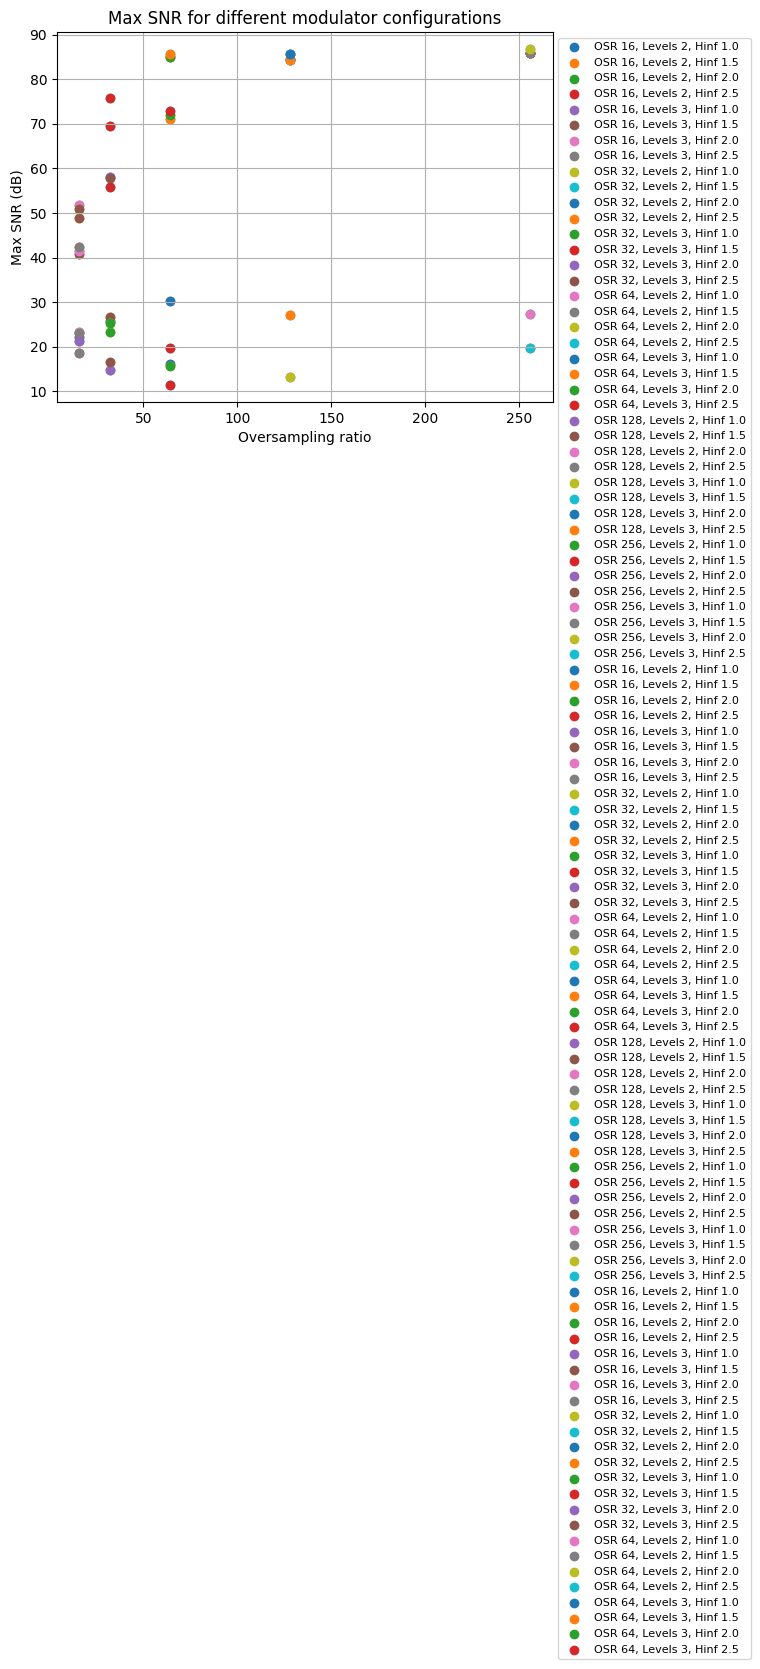

In [7]:
# plot SNR results:
plt.figure()
for order, osr, nlev, Hinf, max_snr in all_results:
    plt.scatter(osr, max_snr, label=f'OSR {osr}, Levels {nlev}, Hinf {Hinf}')
plt.xlabel('Oversampling ratio')
plt.ylabel('Max SNR (dB)')
plt.title('Max SNR for different modulator configurations')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.show()

## Second approach

We are looking for a litte worse solution, one that achieves SNR=85 dB, and then continue searching from there.

In [8]:
# target specifications:
target_SNR2 = 85
Bw = 20e3

In [9]:
# parameter search space:
orders = [2, 3, 4, 5, 6] # modulator order
osr_values = [16, 32, 64, 128, 256] # oversampling ratio
nlev_values = [2, 3] # number of DAC levels
Hinf_values = [1.0, 1.5, 2.0, 2.5] # feedback gain

tdac = [0, 1] # DAC sampling times
form = "FB" # modulator architecture (feedback)

In [10]:
# store results:
best_config = None # best parameter configuration (order, osr, nlev, Hinf)
best_snr = 0 # maximum SNR found
all_results = [] # all tested configurations, and their SNR

In [11]:
# brute-force search:
for order, osr, nlev, Hinf in product(orders, osr_values, nlev_values, Hinf_values):
    # compute the sampling frequency:
    fs = Bw * osr * 2
    print(f"Sampling frequency: {fs / 1e6} MHz")
    
    print("###################################")
    print(f"Testing: order={order}, osr={osr}, nlev={nlev}, Hinf={Hinf}")
    print("###################################")
    
    # synthesize the Noise Transfer Function (NTF):
    ntf = cb.delsig.synthesizeNTF(order, osr, 2, Hinf, 0.0)
    
    # realize the NTF in state-space representation:
    a, g, b, c = cb.delsig.realizeNTF(ntf, form="CRFB")
    ABCD = cb.delsig.stuffABCD(a, g, b, c)
    
    # Create discrete-time analog frontend model:
    dt_analog_frontend = cb.AnalogFrontend.dtsdm(ABCD, nlev)
    
    # run an SNR simulation:
    snr, amp, _ = dt_analog_frontend.simulateSNR(osr)
    max_snr = max(snr)
    
    # store result:
    all_results.append((order, osr, nlev, Hinf, max_snr))
    
    # check if this configuration meets the target SNR:
    if max_snr >= target_SNR2 and (best_config is None or max_snr > best_snr):
        best_snr = max_snr
        best_config = (order, osr, nlev, Hinf)

INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=2, osr=16, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=2, osr=32, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=2, osr=64, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=2, osr=128, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=2, osr=256, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=3, osr=16, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=3, osr=32, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=3, osr=64, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 0.64 MHz
###################################
Testing: order=4, osr=16, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 1.28 MHz
###################################
Testing: order=4, osr=32, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=2, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=2, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=2, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=2, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=3, Hinf=1.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=3, Hinf=1.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=3, Hinf=2.0
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 2.56 MHz
###################################
Testing: order=4, osr=64, nlev=3, Hinf=2.5
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=4, osr=128, nlev=2, Hinf=1.0
###################################


LinAlgError: Failed to find a finite solution.

In [12]:
# display the best configuration:
if best_config:
    print("Best configuration found:")
    print(f"\n\tOrder: {best_config[0]}\n\tOSR: {best_config[1]}\n\tDAC Levels: {best_config[2]}\n\tHinf: {best_config[3]}\n\tSNR: {best_snr:.2f} dB")
else:
    print("No configuration met the target SNR")

Best configuration found:

	Order: 3
	OSR: 256
	DAC Levels: 2
	Hinf: 2.0
	SNR: 86.74 dB


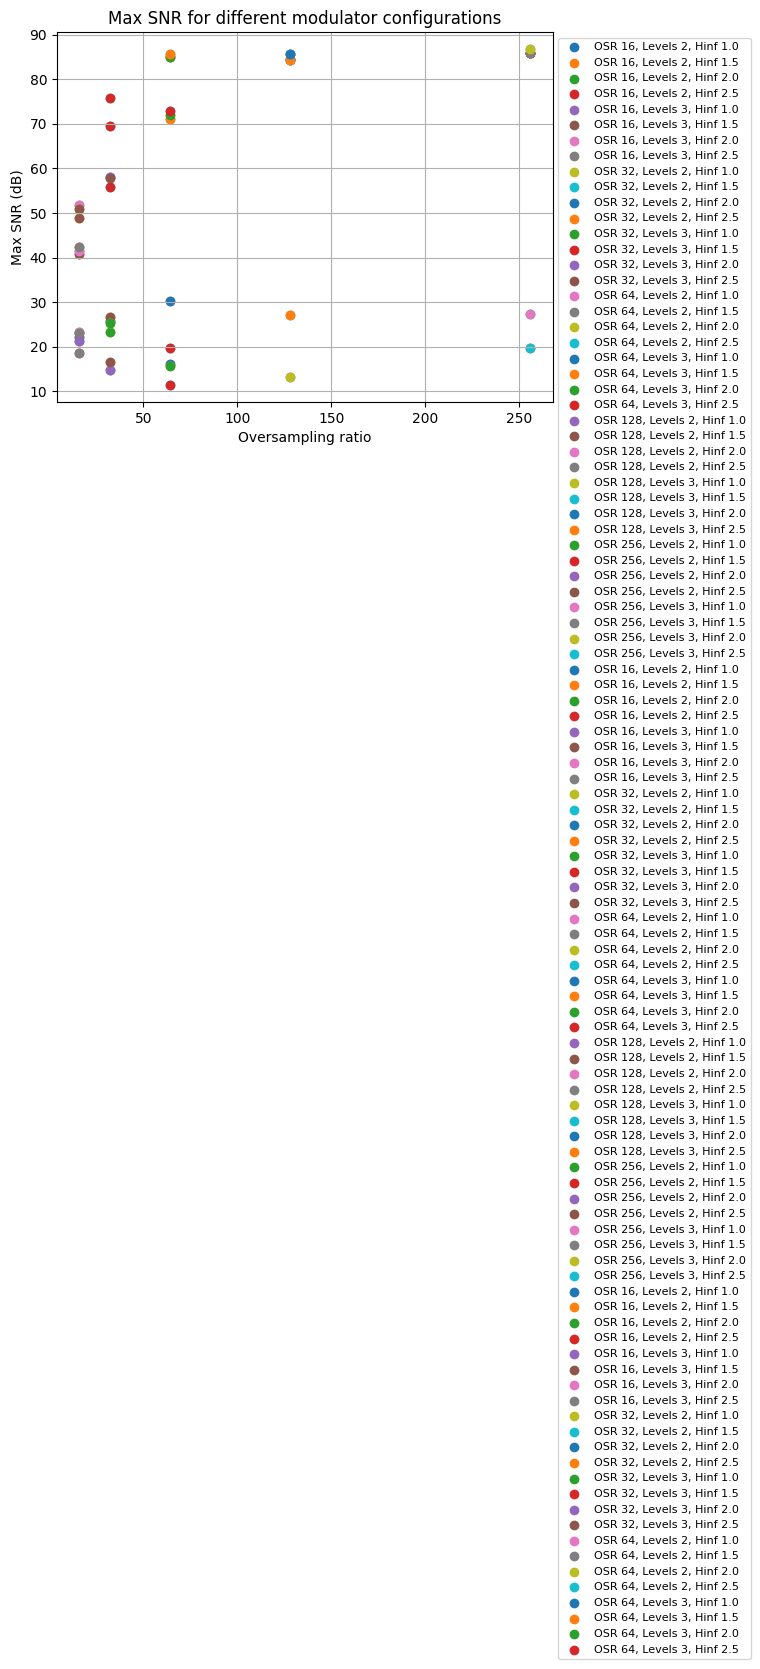

In [13]:
# plot SNR results:
plt.figure()
for order, osr, nlev, Hinf, max_snr in all_results:
    plt.scatter(osr, max_snr, label=f'OSR {osr}, Levels {nlev}, Hinf {Hinf}')
plt.xlabel('Oversampling ratio')
plt.ylabel('Max SNR (dB)')
plt.title('Max SNR for different modulator configurations')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.show()

Let's analyze the results, comparing with the parameter search space we defined previously. It seems that as increasing oversampling ratio, SNR also increases. So, it may means that if we increase OSR, SNR will achieve 90db.

Then, the next step is to repeat the process, but only varying the oversampling ratio.

In [14]:
# target specifications:
target_SNR = 90
Bw = 20e3

In [15]:
# parameter search space:
order = 3 # modulator order
osr_values = [128, 256, 512, 1024] # oversampling ratio
nlev = 3 # number of DAC levels
Hinf_values = [1.5, 2.0] # feedback gain
forms = ["CRFB", "CRFF", "CIFB", "CIFF", "CRFBD", "CRFFD"] # modulator architectures
tdac = [0, 1] # DAC sampling times

In [16]:
# store results:
best_config = None # best parameter configuration (order, osr, nlev, Hinf, form)
best_snr = 0 # maximum SNR found
all_results = [] # all tested configurations, and their SNR

In [17]:
# brute-force search:
for osr, Hinf, form in product(osr_values, Hinf_values, forms):
    # compute the sampling frequency:
    fs = Bw * osr * 2
    print(f"Sampling frequency: {fs / 1e6} MHz")
    
    print("###################################")
    print(f"Testing: order={order}, osr={osr}, nlev={nlev}, Hinf={Hinf}, form={form}")
    print("###################################")
    
    # synthesize the Noise Transfer Function (NTF):
    ntf = cb.delsig.synthesizeNTF(order, osr, 2, Hinf, 0.0)
    
    # realize the NTF in state-space representation:
    a, g, b, c = cb.delsig.realizeNTF(ntf, form)
    ABCD = cb.delsig.stuffABCD(a, g, b, c)
    
    # create discrete-time analog frontend model:
    dt_analog_frontend = cb.AnalogFrontend.dtsdm(ABCD, nlev)
    
    # run an SNR simulation:
    snr, amp, _ = dt_analog_frontend.simulateSNR(osr)
    max_snr = max(snr)
    
    # store result:
    all_results.append((order, osr, nlev, Hinf, form, max_snr))
    
    # check if this configuration meets the target SNR:
    if max_snr >= target_SNR and (best_config is None or max_snr > best_snr):
        best_snr = max_snr
        best_config = (order, osr, nlev, Hinf, form)

INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=1.5, form=CRFB
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=1.5, form=CRFF
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=1.5, form=CIFB
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=1.5, form=CIFF
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=1.5, form=CRFBD
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=1.5, form=CRFFD
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=2.0, form=CRFB
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=2.0, form=CRFF
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=2.0, form=CIFB
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=2.0, form=CIFF
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=2.0, form=CRFBD
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 5.12 MHz
###################################
Testing: order=3, osr=128, nlev=3, Hinf=2.0, form=CRFFD
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=1.5, form=CRFB
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=1.5, form=CRFF
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=1.5, form=CIFB
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=1.5, form=CIFF
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=1.5, form=CRFBD
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=1.5, form=CRFFD
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=2.0, form=CRFB
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=2.0, form=CRFF
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=2.0, form=CIFB
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=2.0, form=CIFF
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=2.0, form=CRFBD
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 10.24 MHz
###################################
Testing: order=3, osr=256, nlev=3, Hinf=2.0, form=CRFFD
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 20.48 MHz
###################################
Testing: order=3, osr=512, nlev=3, Hinf=1.5, form=CRFB
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 20.48 MHz
###################################
Testing: order=3, osr=512, nlev=3, Hinf=1.5, form=CRFF
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 20.48 MHz
###################################
Testing: order=3, osr=512, nlev=3, Hinf=1.5, form=CIFB
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 20.48 MHz
###################################
Testing: order=3, osr=512, nlev=3, Hinf=1.5, form=CIFF
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 20.48 MHz
###################################
Testing: order=3, osr=512, nlev=3, Hinf=1.5, form=CRFBD
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 20.48 MHz
###################################
Testing: order=3, osr=512, nlev=3, Hinf=1.5, form=CRFFD
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 20.48 MHz
###################################
Testing: order=3, osr=512, nlev=3, Hinf=2.0, form=CRFB
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 20.48 MHz
###################################
Testing: order=3, osr=512, nlev=3, Hinf=2.0, form=CRFF
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 20.48 MHz
###################################
Testing: order=3, osr=512, nlev=3, Hinf=2.0, form=CIFB
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 20.48 MHz
###################################
Testing: order=3, osr=512, nlev=3, Hinf=2.0, form=CIFF
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 20.48 MHz
###################################
Testing: order=3, osr=512, nlev=3, Hinf=2.0, form=CRFBD
###################################


INFO:root:Simulating discrete-time analog frontend


Sampling frequency: 20.48 MHz
###################################
Testing: order=3, osr=512, nlev=3, Hinf=2.0, form=CRFFD
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

Sampling frequency: 40.96 MHz
###################################
Testing: order=3, osr=1024, nlev=3, Hinf=1.5, form=CRFB
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

Sampling frequency: 40.96 MHz
###################################
Testing: order=3, osr=1024, nlev=3, Hinf=1.5, form=CRFF
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

Sampling frequency: 40.96 MHz
###################################
Testing: order=3, osr=1024, nlev=3, Hinf=1.5, form=CIFB
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

Sampling frequency: 40.96 MHz
###################################
Testing: order=3, osr=1024, nlev=3, Hinf=1.5, form=CIFF
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

Sampling frequency: 40.96 MHz
###################################
Testing: order=3, osr=1024, nlev=3, Hinf=1.5, form=CRFBD
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

Sampling frequency: 40.96 MHz
###################################
Testing: order=3, osr=1024, nlev=3, Hinf=1.5, form=CRFFD
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

Sampling frequency: 40.96 MHz
###################################
Testing: order=3, osr=1024, nlev=3, Hinf=2.0, form=CRFB
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

Sampling frequency: 40.96 MHz
###################################
Testing: order=3, osr=1024, nlev=3, Hinf=2.0, form=CRFF
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

Sampling frequency: 40.96 MHz
###################################
Testing: order=3, osr=1024, nlev=3, Hinf=2.0, form=CIFB
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

Sampling frequency: 40.96 MHz
###################################
Testing: order=3, osr=1024, nlev=3, Hinf=2.0, form=CIFF
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

Sampling frequency: 40.96 MHz
###################################
Testing: order=3, osr=1024, nlev=3, Hinf=2.0, form=CRFBD
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

Sampling frequency: 40.96 MHz
###################################
Testing: order=3, osr=1024, nlev=3, Hinf=2.0, form=CRFFD
###################################


In [18]:
# display the best configuration:
if best_config:
    print("Best configuration found:")
    print(f"\n\tOrder: {best_config[0]}\n\tOSR: {best_config[1]}\n\tDAC Levels: {best_config[2]}\n\tHinf: {best_config[3]}\n\tForm: {best_config[4]}\n\tSNR: {best_snr:.2f} dB")
else:
    print("No configuration met the target SNR")

Best configuration found:

	Order: 3
	OSR: 1024
	DAC Levels: 3
	Hinf: 2.0
	Form: CRFBD
	SNR: 95.39 dB


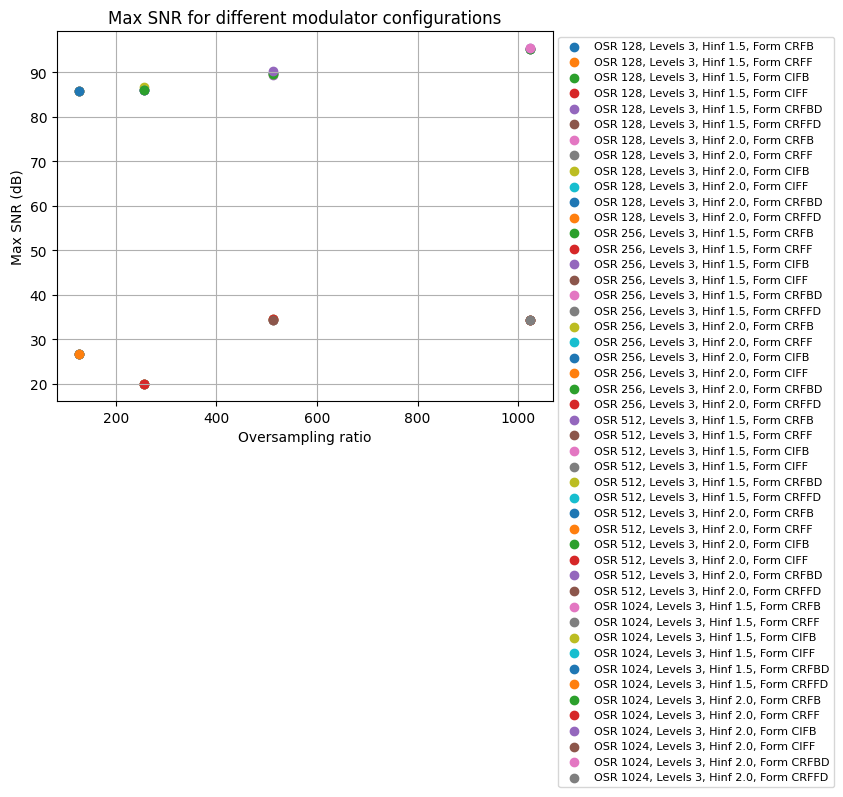

In [19]:
# plot SNR results:
plt.figure()
for order, osr, nlev, Hinf, form, max_snr in all_results:
    plt.scatter(osr, max_snr, label=f'OSR {osr}, Levels {nlev}, Hinf {Hinf}, Form {form}')
plt.xlabel('Oversampling ratio')
plt.ylabel('Max SNR (dB)')
plt.title('Max SNR for different modulator configurations')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.show()

# Finding the optimal implementation

Now we have found the "optimal" SDM configuration, we need to **determine which circuit (Active-RC or Gm-C) is better** for the design.

For each architecture, we need to sweep through different component values and determine the best-performing situation:
    - For Active-RC:
        - Gain-Bandwidth Product
        - DC Gain
    - For Gm-C:
        - Integration Capacitance
        - Output resistance
        - Parasitic capacitance
        - Input noise density
        - Slew rate
        - Output voltange range

## First approach

In [20]:
# optimal modulator parameters from brute-force search:
order = 3 # modulator order
osr = 1024 # oversampling ratio
nlev = 3 # number of DAC levels
f0 = 0. # input frequency (0 for baseband)
Hinf = 2.0 # feedback gain
tdac = [0, 1] # DAC sampling times
form = "FB" # modulator architecture (feedback)
dt_form = "CRFBD" # time-domain structure
Bw = 20e3 # bandwidth

# compute the sampling frequency:
fs = Bw * osr * 2
print(f"Sampling frequency: {fs / 1e6} MHz")

# rescale to fs:
dt = 1.0 / fs

Sampling frequency: 40.96 MHz


In [21]:
# synthesize the optimal NTF:
ntf = cb.delsig.synthesizeNTF(order, osr, 2, Hinf, f0)

# realize the NTF in state-space representation:
a, g, b, c = cb.delsig.realizeNTF(ntf, form)
ABCD = cb.delsig.stuffABCD(a, g, b, c)

# transform the DT NTF into its CT equivalent:
ABCDc, tdac2 = cb.delsig.realizeNTF_ct(ntf, form, tdac)

C:\Users\frang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\signal\_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)
C:\Users\frang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\signal\_filter_design.py:1125: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


In [22]:
analog_frontend = cb.AnalogFrontend.ctsdm(ABCDc, tdac2, dt, nlev)
analog_frontend.dt = 1.0 / fs # probably not necessary?

In [23]:
# parameter search space for Active-RC implementation:
Cint_values = [100e-15, 500e-15, 1e-12, 10e-12] # integration capacitance (F)
gm_values = [1e-6, 1e-5, 1e-4] # transconductance (S)
Ro_values = [1e4, 1e5, 1e6, 1e7] # internal resistance (Ohm)
Co_values = [1e-15, 100e-15, 1e-12] # internal capacitance (F)

# store results:
best_snr_ActiveRC = 0 # maximum SNR found
best_config_ActiveRC = None # best parameter configuration (Cint, gm, Ro, Co)
all_results_ActiveRC = [] # all tested configurations, and their SNR

In [24]:
# brute-force search for Active-RC:
for Cint, gm, Ro, Co in product(Cint_values, gm_values, Ro_values, Co_values):
    print("###################################")
    print(f"Testing Active-RC implementation: Cint={Cint}, gm={gm}, Ro={Ro}, Co={Co}")
    print("###################################")
    
    Cint = np.ones(order) * Cint
    gm = np.ones(order) * gm
    Ro = np.ones(order) * Ro
    Co = np.ones(order) * Co
    
    ActiveRC_analog_frontend = cb.ActiveRC(
        analog_frontend, Cint, gm, Ro, Co
    )
    
    snr_ActiveRC, amp_ActiveRC, _ = ActiveRC_analog_frontend.simulateSNR(osr)
    max_snr_ActiveRC = max(snr_ActiveRC)
    
    all_results_ActiveRC.append((Cint, gm, Ro, Co, max_snr_ActiveRC))
    
    if max_snr_ActiveRC > best_snr_ActiveRC:
        best_snr_ActiveRC = max_snr_ActiveRC
        best_config_ActiveRC = (Cint, gm, Ro, Co)

--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Active-RC implementation: Cint=1e-13, gm=1e-06, Ro=10000.0, Co=1e-15
###################################


ValueError: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.

In [25]:
# parameter search space for Gm-C implementation:
Cint_values = [100e-15, 500e-15, 1e-12, 10e-12] # integration capacitance (F)
Ro_values = [1e4, 1e5, 1e6, 1e7] # output resistance (Ohm)
Cp_values = [1e-15, 100e-15, 1e-12] # parasitic capacitance (F)
v_n_values = [10e-6, 100e-6, 1e-3] # input noise density (V rms)
slew_rate_values = [1e6, 1e9, 1e12] # slew rate (V/s)
output_swing_values = [0.5, 1.0, 2.0] # output voltage swing (V)

# store results:
best_snr_GmC = 0 # maximum SNR found
best_config_GmC = None # best parameter configuration (Cint, Ro, Cp, v_n, slew_rate, v_out_max)
all_results_GmC = [] # all tested configurations, and their SNR

In [26]:
# brute-force search for Gm-C:
for Cint, Ro, Cp, v_n, slew_rate, output_swing in product(Cint_values, Ro_values, Cp_values, v_n_values, slew_rate_values, output_swing_values):
    print("###################################")
    print(f"Testing Gm-C implementation: Cint={Cint}, Ro={Ro}, Cp={Cp}, v_n={v_n}, slew_rate={slew_rate}, output_swing={output_swing}")
    print("###################################")
    
    Cint = np.ones(order) * Cint
    Ro = np.ones(order) * Ro
    Cp = np.ones(order) * Cp
    v_n = np.ones(order) * v_n
    slew_rate = np.ones(order) * slew_rate
    v_out_max = np.ones(order) * output_swing
    v_out_min = -v_out_max
       
    GmC_analog_frontend = cb.GmC(
        analog_frontend, Cint, Ro, Cp, v_n, v_out_max, v_out_min, slew_rate
    )
    
    snr_GmC, amp_GmC, _ = GmC_analog_frontend.simulateSNR(osr)
    max_snr_GmC = max(snr_GmC)
    
    all_results_GmC.append((Cint, Ro, Cp, v_n, slew_rate, output_swing, max_snr_GmC))
    
    if max_snr_GmC > best_snr_GmC:
        best_snr_GmC = max_snr_GmC
        best_config_GmC = (Cint, Ro, Cp, v_n, slew_rate, v_out_max)

--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=1e-05, slew_rate=1000000.0, output_swing=0.5
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=1e-05, slew_rate=1000000.0, output_swing=1.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=1e-05, slew_rate=1000000.0, output_swing=2.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=1e-05, slew_rate=1000000000.0, output_swing=0.5
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=1e-05, slew_rate=1000000000.0, output_swing=1.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=1e-05, slew_rate=1000000000.0, output_swing=2.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=1e-05, slew_rate=1000000000000.0, output_swing=0.5
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=1e-05, slew_rate=1000000000000.0, output_swing=1.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=1e-05, slew_rate=1000000000000.0, output_swing=2.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.0001, slew_rate=1000000.0, output_swing=0.5
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.0001, slew_rate=1000000.0, output_swing=1.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.0001, slew_rate=1000000.0, output_swing=2.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.0001, slew_rate=1000000000.0, output_swing=0.5
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.0001, slew_rate=1000000000.0, output_swing=1.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.0001, slew_rate=1000000000.0, output_swing=2.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.0001, slew_rate=1000000000000.0, output_swing=0.5
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.0001, slew_rate=1000000000000.0, output_swing=1.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.0001, slew_rate=1000000000000.0, output_swing=2.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.001, slew_rate=1000000.0, output_swing=0.5
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.001, slew_rate=1000000.0, output_swing=1.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.001, slew_rate=1000000.0, output_swing=2.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.001, slew_rate=1000000000.0, output_swing=0.5
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.001, slew_rate=1000000000.0, output_swing=1.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.001, slew_rate=1000000000.0, output_swing=2.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.001, slew_rate=1000000000000.0, output_swing=0.5
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.001, slew_rate=1000000000000.0, output_swing=1.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-15, v_n=0.001, slew_rate=1000000000000.0, output_swing=2.0
###################################


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

###################################
Testing Gm-C implementation: Cint=1e-13, Ro=10000.0, Cp=1e-13, v_n=1e-05, slew_rate=1000000.0, output_swing=0.5
###################################


ValueError: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.

In [27]:
# display best configurations:
print("Best Active-RC configuration:")
print(f"\n\tCint: {best_config_ActiveRC[0][0]} F\n\tgm: {best_config_ActiveRC[1][0]} S\n\tRo: {best_config_ActiveRC[2][0]} Ohm\n\tCo: {best_config_ActiveRC[3][0]} F\n\tSNR: {best_snr_ActiveRC:.2f} dB")
print("\nBest Gm-C configuration:")
print(f"\n\tCint: {best_config_GmC[0][0]} F\n\tRo: {best_config_GmC[1][0]} Ohm\n\tCp: {best_config_GmC[2][0]} F\n\tv_n: {best_config_GmC[3][0]} V\n\tSlew rate: {best_config_GmC[4][0]} V/s\n\tOutput range: +-{best_config_GmC[5][0]} V\n\tSNR: {best_snr_GmC:.2f} dB")

Best Active-RC configuration:


TypeError: 'NoneType' object is not subscriptable

In [28]:
# compare results and determine the best implementation:
if best_snr_ActiveRC > best_snr_GmC:
    print("Active-RC is the optimal implementation")
else:
    print("Gm-C is the optimal implementation")

Gm-C is the optimal implementation


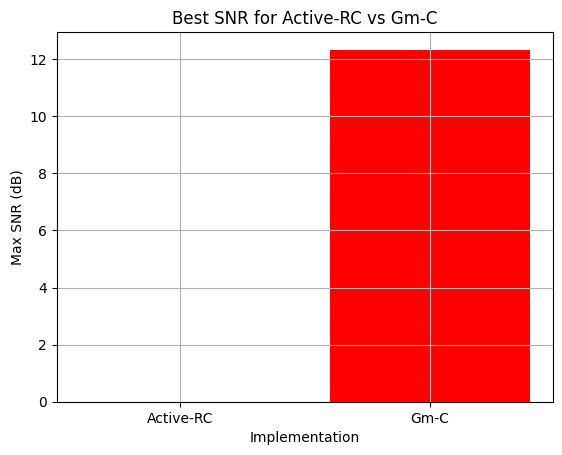

In [29]:
# plot SNR results:
plt.figure()
plt.bar(['Active-RC', 'Gm-C'], [best_snr_ActiveRC, best_snr_GmC], color=['blue', 'red'])
plt.xlabel('Implementation')
plt.ylabel('Max SNR (dB)')
plt.title('Best SNR for Active-RC vs Gm-C')
plt.grid()
plt.show()

NameError: name 'amp_ActiveRC' is not defined

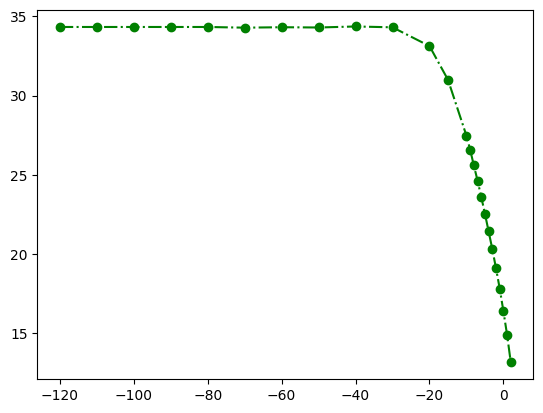

In [30]:
# plot SNR results:
plt.figure()
plt.plot(amp, snr, 'o-.g', label='Ideal CT implementation')
plt.plot(amp_ActiveRC, snr_ActiveRC, 'o-.r', label='Active-RC')
plt.plot(amp_GmC, snr_GmC, 'o-.b', label='Gm-C')
plt.xlabel('Input Level (dBFS)')
plt.ylabel('SQNR (dB)')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

## Second approach

In [31]:
# "optimal" modulator parameters from brute-force search:
order = 3 # modulator order
osr = 512 # oversampling ratio
nlev = 3 # number of DAC levels
f0 = 0. # input frequency (0 for baseband)
Hinf = 2.0 # feedback gain
tdac = [0, 1] # DAC sampling times
form = "FB" # modulator architecture (feedback)
dt_form = "CRFBD" # time-domain structure
Bw = 20e3 # bandwidth

# compute the sampling frequency:
fs = Bw * osr * 2
print(f"Sampling frequency: {fs / 1e6} MHz")

# rescale to fs:
dt = 1.0 / fs

Sampling frequency: 20.48 MHz


In [32]:
# synthesize the optimal NTF:
ntf = cb.delsig.synthesizeNTF(order, osr, 2, Hinf, f0)

# realize the NTF in state-space representation:
a, g, b, c = cb.delsig.realizeNTF(ntf, dt_form)
ABCD = cb.delsig.stuffABCD(a, g, b, c)

# create discrete-time analog frontend model:
dt_analog_frontend = cb.AnalogFrontend.dtsdm(ABCD, nlev)
    
# run an SNR simulation:
snr, amp, _ = dt_analog_frontend.simulateSNR(osr)
max_snr = max(snr)
print(f"SNR = {max_snr} db")

INFO:root:Simulating discrete-time analog frontend


SNR = 90.18351828633857 db


We lose in SNR, but it's still greater than 90 db.

In [33]:
# transform the DT NTF into its CT equivalent:
ABCDc, tdac2 = cb.delsig.realizeNTF_ct(ntf, form, tdac)

analog_frontend = cb.AnalogFrontend.ctsdm(ABCDc, tdac2, dt, nlev)
analog_frontend.dt = 1.0 / fs # probably not necessary

C:\Users\frang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\signal\_ltisys.py:3137: ComplexWarning: Casting complex values to real discards the imaginary part
  yout[i, :] = (np.dot(system.C, xout[i, :]) +
C:\Users\frang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\signal\_ltisys.py:3141: ComplexWarning: Casting complex values to real discards the imaginary part
  yout[out_samples-1, :] = (np.dot(system.C, xout[out_samples-1, :]) +


In [34]:
# parameter search space for Active-RC implementation:
Cint_values = [1e-12] # integration capacitance (F)
gm_values = [1e-4] # transconductance (S)
Ro_values = [1e4] # internal resistance (Ohm)
Co_values = [1e-12] # internal capacitance (F)

# store results:
best_snr_ActiveRC = 0 # maximum SNR found
best_config_ActiveRC = None # best parameter configuration (Cint, gm, Ro, Co)
all_results_ActiveRC = [] # all tested configurations, and their SNR

In [35]:
# brute-force search for Active-RC (only one value):
for Cint, gm, Ro, Co in product(Cint_values, gm_values, Ro_values, Co_values):
    print("###################################")
    print(f"Testing Active-RC implementation: Cint={Cint}, gm={gm}, Ro={Ro}, Co={Co}")
    print("###################################")
    
    Cint = np.ones(order) * Cint
    gm = np.ones(order) * gm
    Ro = np.ones(order) * Ro
    Co = np.ones(order) * Co
    
    ActiveRC_analog_frontend = cb.ActiveRC(
        analog_frontend, Cint, gm, Ro, Co
    )
    
    snr_ActiveRC, amp_ActiveRC, _ = ActiveRC_analog_frontend.simulateSNR(osr)
    max_snr_ActiveRC = max(snr_ActiveRC)
    
    all_results_ActiveRC.append((Cint, gm, Ro, Co, max_snr_ActiveRC))
    
    if max_snr_ActiveRC > best_snr_ActiveRC:
        best_snr_ActiveRC = max_snr_ActiveRC
        best_config_ActiveRC = (Cint, gm, Ro, Co)

INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.0001, Ro=10000.0, Co=1e-12
###################################


In [36]:
# parameter search space for Gm-C implementation:
Cint_values = [1e-12] # integration capacitance (F)
Ro_values = [1e4] # output resistance (Ohm)
Cp_values = [1e-12] # parasitic capacitance (F)
v_n_values = [1e-3] # input noise density (V rms)
slew_rate_values = [1e-3] # slew rate (V/s)
output_swing_values = [1.0] # output voltage swing (V)

# store results:
best_snr_GmC = 0 # maximum SNR found
best_config_GmC = None # best parameter configuration (Cint, Ro, Cp, v_n, slew_rate, v_out_max)
all_results_GmC = [] # all tested configurations, and their SNR

In [37]:
# brute-force search for Gm-C (only one value):
for Cint, Ro, Cp, v_n, slew_rate, output_swing in product(Cint_values, Ro_values, Cp_values, v_n_values, slew_rate_values, output_swing_values):
    print("###################################")
    print(f"Testing Gm-C implementation: Cint={Cint}, Ro={Ro}, Cp={Cp}, v_n={v_n}, slew_rate={slew_rate}, output_swing={output_swing}")
    print("###################################")
    
    Cint = np.ones(order) * Cint
    Ro = np.ones(order) * Ro
    Cp = np.ones(order) * Cp
    v_n = np.ones(order) * v_n
    slew_rate = np.ones(order) * slew_rate
    v_out_max = np.ones(order) * output_swing
    v_out_min = -v_out_max
       
    GmC_analog_frontend = cb.GmC(
        analog_frontend, Cint, Ro, Cp, v_n, v_out_max, v_out_min, slew_rate
    )
    
    snr_GmC, amp_GmC, _ = GmC_analog_frontend.simulateSNR(osr)
    max_snr_GmC = max(snr_GmC)
    
    all_results_GmC.append((Cint, Ro, Cp, v_n, slew_rate, output_swing, max_snr_GmC))
    
    if max_snr_GmC > best_snr_GmC:
        best_snr_GmC = max_snr_GmC
        best_config_GmC = (Cint, Ro, Cp, v_n, slew_rate, v_out_max)

INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-12, Ro=10000.0, Cp=1e-12, v_n=0.001, slew_rate=0.001, output_swing=1.0
###################################


In [38]:
# display best configurations:
print("Best Active-RC configuration:")
print(f"\n\tCint: {best_config_ActiveRC[0][0]} F\n\tgm: {best_config_ActiveRC[1][0]} S\n\tRo: {best_config_ActiveRC[2][0]} Ohm\n\tCo: {best_config_ActiveRC[3][0]} F\n\tSNR: {best_snr_ActiveRC:.2f} dB")
print("\nBest Gm-C configuration:")
print(f"\n\tCint: {best_config_GmC[0][0]} F\n\tRo: {best_config_GmC[1][0]} Ohm\n\tCp: {best_config_GmC[2][0]} F\n\tv_n: {best_config_GmC[3][0]} V\n\tSlew rate: {best_config_GmC[4][0]} V/s\n\tOutput range: +-{best_config_GmC[5][0]} V\n\tSNR: {best_snr_GmC:.2f} dB")

Best Active-RC configuration:

	Cint: 1e-12 F
	gm: 0.0001 S
	Ro: 10000.0 Ohm
	Co: 1e-12 F
	SNR: 66.52 dB

Best Gm-C configuration:

	Cint: 1e-12 F
	Ro: 10000.0 Ohm
	Cp: 1e-12 F
	v_n: 0.001 V
	Slew rate: 0.001 V/s
	Output range: +-1.0 V
	SNR: 12.33 dB


In [39]:
# compare results and determine the best implementation:
if best_snr_ActiveRC > best_snr_GmC:
    print("Active-RC is the optimal implementation")
else:
    print("Gm-C is the optimal implementation")

Active-RC is the optimal implementation


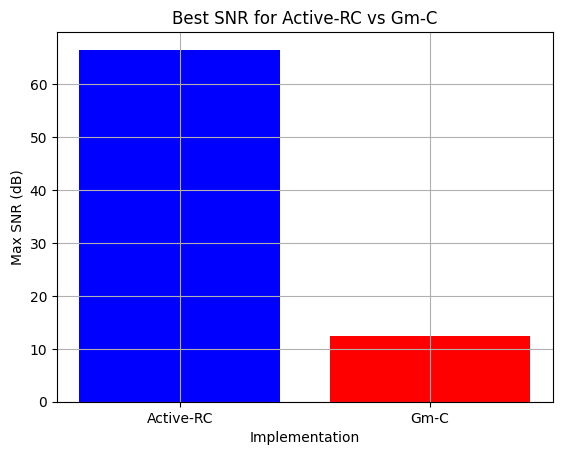

In [40]:
# plot SNR results:
plt.figure()
plt.bar(['Active-RC', 'Gm-C'], [best_snr_ActiveRC, best_snr_GmC], color=['blue', 'red'])
plt.xlabel('Implementation')
plt.ylabel('Max SNR (dB)')
plt.title('Best SNR for Active-RC vs Gm-C')
plt.grid()
plt.show()

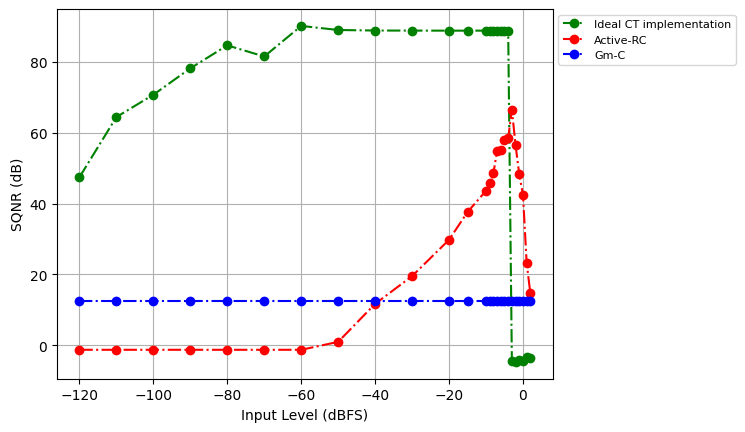

In [41]:
# plot SNR results:
plt.figure()
plt.plot(amp, snr, 'o-.g', label='Ideal CT implementation')
plt.plot(amp_ActiveRC, snr_ActiveRC, 'o-.r', label='Active-RC')
plt.plot(amp_GmC, snr_GmC, 'o-.b', label='Gm-C')
plt.xlabel('Input Level (dBFS)')
plt.ylabel('SQNR (dB)')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

Of course, both implementations are much worse than the ideal continuous-time modulator, since we have chosen some values randomly. Therefore, the next step is to apply exactly the same code, but varying the parameter values for each Active-RC and Gm-C implementation.

## Third approach

In [42]:
from numpy.linalg import LinAlgError

In [43]:
# "optimal" modulator parameters from brute-force search:
order = 3 # modulator order
osr = 512 # oversampling ratio
nlev = 3 # number of DAC levels
f0 = 0. # input frequency (0 for baseband)
Hinf = 2.0 # feedback gain
tdac = [0, 1] # DAC sampling times
form = "FB" # modulator architecture (feedback)
dt_form = "CRFBD" # time-domain structure
Bw = 20e3 # bandwidth

# compute the sampling frequency:
fs = Bw * osr * 2
print(f"Sampling frequency: {fs / 1e6} MHz")

# rescale to fs:
dt = 1.0 / fs

Sampling frequency: 20.48 MHz


In [44]:
# synthesize the optimal NTF:
ntf = cb.delsig.synthesizeNTF(order, osr, 2, Hinf, f0)

# realize the NTF in state-space representation:
a, g, b, c = cb.delsig.realizeNTF(ntf, dt_form)
ABCD = cb.delsig.stuffABCD(a, g, b, c)

# create discrete-time analog frontend model:
dt_analog_frontend = cb.AnalogFrontend.dtsdm(ABCD, nlev)
    
# run an SNR simulation:
snr, amp, _ = dt_analog_frontend.simulateSNR(osr)
max_snr = max(snr)
print(f"SNR = {max_snr} db")

INFO:root:Simulating discrete-time analog frontend


SNR = 90.18351828633857 db


In [45]:
# transform the DT NTF into its CT equivalent:
ABCDc, tdac2 = cb.delsig.realizeNTF_ct(ntf, form, tdac)

analog_frontend = cb.AnalogFrontend.ctsdm(ABCDc, tdac2, dt, nlev)
analog_frontend.dt = 1.0 / fs # probably not necessary

In [46]:
# parameter search space for Active-RC implementation:
Cint_values = [1e-12, 5e-12, 1e-11, 2e-11] # integration capacitance (F)
gm_values = [0.001, 0.002, 0.005, 0.01] # transconductance (S)
Ro_values = [1e4, 5e4, 1e5, 2e5] # internal resistance (Ohm)
Co_values = [1e-12, 5e-12, 1e-11, 2e-11] # internal capacitance (F)

# store results:
best_snr_ActiveRC = -np.inf # maximum SNR found
best_config_ActiveRC = None # best parameter configuration (Cint, gm, Ro, Co)
all_results_ActiveRC = [] # all tested configurations, and their SNR
best_snr_values_ActiveRC = None # SNR values of the best configuration
best_amp_values_ActiveRC = None # amplitude values of the best configuration

In [47]:
# brute-force search for Active-RC:
for Cint, gm, Ro, Co in product(Cint_values, gm_values, Ro_values, Co_values):
    print("###################################")
    print(f"Testing Active-RC implementation: Cint={Cint}, gm={gm}, Ro={Ro}, Co={Co}")
    print("###################################")
    
    Cint = np.ones(order) * Cint
    gm = np.ones(order) * gm
    Ro = np.ones(order) * Ro
    Co = np.ones(order) * Co
    
    try:
        ActiveRC_analog_frontend = cb.ActiveRC(
            analog_frontend, Cint, gm, Ro, Co
        )

        snr_ActiveRC, amp_ActiveRC, _ = ActiveRC_analog_frontend.simulateSNR(osr)
        max_snr_ActiveRC = max(snr_ActiveRC)
        
        if not np.isnan(max_snr_ActiveRC):
            all_results_ActiveRC.append((Cint, gm, Ro, Co, max_snr_ActiveRC))

            if max_snr_ActiveRC > best_snr_ActiveRC:
                best_snr_ActiveRC = max_snr_ActiveRC
                best_config_ActiveRC = (Cint, gm, Ro, Co)
                best_snr_values_ActiveRC = snr_ActiveRC
                best_amp_values_ActiveRC = amp_ActiveRC
                # print(snr_GmC, amp_GmC) # show the best configuration until now, to see how to vary parameters
        else:
            print(f"Skipping NaN result for Cint={Cint}, gm={gm}, Ro={Ro}, Co={Co}")
        
    except (LinAlgError, ValueError) as e:
        print(f"Error encountered with Cint={Cint}, gm={gm}, Ro={Ro}, Co={Co}. Skipping this configuration")

INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=100000.0, Co=1e-12
###################################


C:\Users\frang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cbadc\digital_backend.py:241: RuntimeWarning: overflow encountered in matmul
  m_v[i + 1] = self._Ab @ m_v[i + 2] + self._Bb @ s[i]
INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-12 1.e-12 1.e-12], gm=[0.001 0.001 0.001], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.001, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.002 0.002 0.002], Ro=[10000. 10000. 10000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.002 0.002 0.002], Ro=[50000. 50000. 50000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-12 1.e-12 1.e-12], gm=[0.002 0.002 0.002], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.002 0.002 0.002], Ro=[200000. 200000. 200000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=200000.0, Co=5e-12
###################################


C:\Users\frang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cbadc\digital_backend.py:241: RuntimeWarning: invalid value encountered in matmul
  m_v[i + 1] = self._Ab @ m_v[i + 2] + self._Bb @ s[i]
INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-12 1.e-12 1.e-12], gm=[0.002 0.002 0.002], Ro=[200000. 200000. 200000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.002, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.005 0.005 0.005], Ro=[10000. 10000. 10000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.005 0.005 0.005], Ro=[50000. 50000. 50000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-12 1.e-12 1.e-12], gm=[0.005 0.005 0.005], Ro=[50000. 50000. 50000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.005 0.005 0.005], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.005 0.005 0.005], Ro=[100000. 100000. 100000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.005 0.005 0.005], Ro=[200000. 200000. 200000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.005 0.005 0.005], Ro=[200000. 200000. 200000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-12 1.e-12 1.e-12], gm=[0.005 0.005 0.005], Ro=[200000. 200000. 200000.], Co=[1.e-11 1.e-11 1.e-11]
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.005, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.01 0.01 0.01], Ro=[10000. 10000. 10000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.01 0.01 0.01], Ro=[10000. 10000. 10000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-12 1.e-12 1.e-12], gm=[0.01 0.01 0.01], Ro=[10000. 10000. 10000.], Co=[1.e-11 1.e-11 1.e-11]
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.01 0.01 0.01], Ro=[50000. 50000. 50000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.01 0.01 0.01], Ro=[50000. 50000. 50000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.01 0.01 0.01], Ro=[50000. 50000. 50000.], Co=[1.e-11 1.e-11 1.e-11]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-12 1.e-12 1.e-12], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[1.e-11 1.e-11 1.e-11]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-12 1.e-12 1.e-12], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[2.e-11 2.e-11 2.e-11]
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-12 1.e-12 1.e-12], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-12 1.e-12 1.e-12], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-12 1.e-12 1.e-12], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[1.e-11 1.e-11 1.e-11]
###################################
Testing Active-RC implementation: Cint=1e-12, gm=0.01, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-12 1.e-12 1.e-12], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[2.e-11 2.e-11 2.e-11]
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[5.e-12 5.e-12 5.e-12], gm=[0.001 0.001 0.001], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.001, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.002 0.002 0.002], Ro=[10000. 10000. 10000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.002 0.002 0.002], Ro=[50000. 50000. 50000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[5.e-12 5.e-12 5.e-12], gm=[0.002 0.002 0.002], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.002 0.002 0.002], Ro=[200000. 200000. 200000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[5.e-12 5.e-12 5.e-12], gm=[0.002 0.002 0.002], Ro=[200000. 200000. 200000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.002, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.005 0.005 0.005], Ro=[10000. 10000. 10000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.005 0.005 0.005], Ro=[50000. 50000. 50000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[5.e-12 5.e-12 5.e-12], gm=[0.005 0.005 0.005], Ro=[50000. 50000. 50000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.005 0.005 0.005], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.005 0.005 0.005], Ro=[100000. 100000. 100000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.005 0.005 0.005], Ro=[200000. 200000. 200000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.005 0.005 0.005], Ro=[200000. 200000. 200000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[5.e-12 5.e-12 5.e-12], gm=[0.005 0.005 0.005], Ro=[200000. 200000. 200000.], Co=[1.e-11 1.e-11 1.e-11]
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.005, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.01 0.01 0.01], Ro=[10000. 10000. 10000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.01 0.01 0.01], Ro=[10000. 10000. 10000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[5.e-12 5.e-12 5.e-12], gm=[0.01 0.01 0.01], Ro=[10000. 10000. 10000.], Co=[1.e-11 1.e-11 1.e-11]
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.01 0.01 0.01], Ro=[50000. 50000. 50000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.01 0.01 0.01], Ro=[50000. 50000. 50000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.01 0.01 0.01], Ro=[50000. 50000. 50000.], Co=[1.e-11 1.e-11 1.e-11]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[5.e-12 5.e-12 5.e-12], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[1.e-11 1.e-11 1.e-11]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[5.e-12 5.e-12 5.e-12], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[2.e-11 2.e-11 2.e-11]
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[5.e-12 5.e-12 5.e-12], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[5.e-12 5.e-12 5.e-12], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[5.e-12 5.e-12 5.e-12], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[1.e-11 1.e-11 1.e-11]
###################################
Testing Active-RC implementation: Cint=5e-12, gm=0.01, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[5.e-12 5.e-12 5.e-12], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[2.e-11 2.e-11 2.e-11]
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-11 1.e-11 1.e-11], gm=[0.001 0.001 0.001], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.001, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.002 0.002 0.002], Ro=[10000. 10000. 10000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.002 0.002 0.002], Ro=[50000. 50000. 50000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-11 1.e-11 1.e-11], gm=[0.002 0.002 0.002], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.002 0.002 0.002], Ro=[200000. 200000. 200000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-11 1.e-11 1.e-11], gm=[0.002 0.002 0.002], Ro=[200000. 200000. 200000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.002, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.005 0.005 0.005], Ro=[10000. 10000. 10000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.005 0.005 0.005], Ro=[50000. 50000. 50000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-11 1.e-11 1.e-11], gm=[0.005 0.005 0.005], Ro=[50000. 50000. 50000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.005 0.005 0.005], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.005 0.005 0.005], Ro=[100000. 100000. 100000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.005 0.005 0.005], Ro=[200000. 200000. 200000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.005 0.005 0.005], Ro=[200000. 200000. 200000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-11 1.e-11 1.e-11], gm=[0.005 0.005 0.005], Ro=[200000. 200000. 200000.], Co=[1.e-11 1.e-11 1.e-11]
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.005, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.01 0.01 0.01], Ro=[10000. 10000. 10000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.01 0.01 0.01], Ro=[10000. 10000. 10000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-11 1.e-11 1.e-11], gm=[0.01 0.01 0.01], Ro=[10000. 10000. 10000.], Co=[1.e-11 1.e-11 1.e-11]
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.01 0.01 0.01], Ro=[50000. 50000. 50000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.01 0.01 0.01], Ro=[50000. 50000. 50000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.01 0.01 0.01], Ro=[50000. 50000. 50000.], Co=[1.e-11 1.e-11 1.e-11]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-11 1.e-11 1.e-11], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[1.e-11 1.e-11 1.e-11]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-11 1.e-11 1.e-11], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[2.e-11 2.e-11 2.e-11]
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[1.e-11 1.e-11 1.e-11], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-11 1.e-11 1.e-11], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-11 1.e-11 1.e-11], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[1.e-11 1.e-11 1.e-11]
###################################
Testing Active-RC implementation: Cint=1e-11, gm=0.01, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[1.e-11 1.e-11 1.e-11], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[2.e-11 2.e-11 2.e-11]
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[2.e-11 2.e-11 2.e-11], gm=[0.001 0.001 0.001], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.001, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.002 0.002 0.002], Ro=[10000. 10000. 10000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.002 0.002 0.002], Ro=[50000. 50000. 50000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[2.e-11 2.e-11 2.e-11], gm=[0.002 0.002 0.002], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.002 0.002 0.002], Ro=[200000. 200000. 200000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[2.e-11 2.e-11 2.e-11], gm=[0.002 0.002 0.002], Ro=[200000. 200000. 200000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.002, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.005 0.005 0.005], Ro=[10000. 10000. 10000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.005 0.005 0.005], Ro=[50000. 50000. 50000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[2.e-11 2.e-11 2.e-11], gm=[0.005 0.005 0.005], Ro=[50000. 50000. 50000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.005 0.005 0.005], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.005 0.005 0.005], Ro=[100000. 100000. 100000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.005 0.005 0.005], Ro=[200000. 200000. 200000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.005 0.005 0.005], Ro=[200000. 200000. 200000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[2.e-11 2.e-11 2.e-11], gm=[0.005 0.005 0.005], Ro=[200000. 200000. 200000.], Co=[1.e-11 1.e-11 1.e-11]
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.005, Ro=200000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=10000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.01 0.01 0.01], Ro=[10000. 10000. 10000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=10000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.01 0.01 0.01], Ro=[10000. 10000. 10000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=10000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[2.e-11 2.e-11 2.e-11], gm=[0.01 0.01 0.01], Ro=[10000. 10000. 10000.], Co=[1.e-11 1.e-11 1.e-11]
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=10000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=50000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.01 0.01 0.01], Ro=[50000. 50000. 50000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=50000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.01 0.01 0.01], Ro=[50000. 50000. 50000.], Co=[5.e-12 5.e-12 5.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=50000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.01 0.01 0.01], Ro=[50000. 50000. 50000.], Co=[1.e-11 1.e-11 1.e-11]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=50000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=100000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=100000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[2.e-11 2.e-11 2.e-11], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=100000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[1.e-11 1.e-11 1.e-11]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=100000.0, Co=2e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[2.e-11 2.e-11 2.e-11], gm=[0.01 0.01 0.01], Ro=[100000. 100000. 100000.], Co=[2.e-11 2.e-11 2.e-11]
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=200000.0, Co=1e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Error encountered with Cint=[2.e-11 2.e-11 2.e-11], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[1.e-12 1.e-12 1.e-12]. Skipping this configuration
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=200000.0, Co=5e-12
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[2.e-11 2.e-11 2.e-11], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[5.e-12 5.e-12 5.e-12]
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=200000.0, Co=1e-11
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Skipping NaN result for Cint=[2.e-11 2.e-11 2.e-11], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[1.e-11 1.e-11 1.e-11]
###################################
Testing Active-RC implementation: Cint=2e-11, gm=0.01, Ro=200000.0, Co=2e-11
###################################
Skipping NaN result for Cint=[2.e-11 2.e-11 2.e-11], gm=[0.01 0.01 0.01], Ro=[200000. 200000. 200000.], Co=[2.e-11 2.e-11 2.e-11]


In [48]:
# parameter search space for Gm-C implementation:
Cint_values = [1e-11, 2e-11] # integration capacitance (F)
Ro_values = [10e3, 20e3] # output resistance (Ohm)
Cp_values = [1e-11, 1e-10] # parasitic capacitance (F)
v_n_values = [1e-3, 5e-3] # input noise density (V rms)
slew_rate_values = [5e-4, 5e-5]  # slew rate (V/s)
output_swing_values = [1.0] # output voltage swing (V)

# store results:
best_snr_GmC = -np.inf # maximum SNR found
best_config_GmC = None # best parameter configuration (Cint, Ro, Cp, v_n, slew_rate, v_out_max)
all_results_GmC = [] # all tested configurations, and their SNR
best_snr_values_GmC = None # SNR values of the best configuration
best_amp_values_GmC = None # amplitude values of the best configuration

In [49]:
# brute-force search for Gm-C:
for Cint, Ro, Cp, v_n, slew_rate, output_swing in product(Cint_values, Ro_values, Cp_values, v_n_values, slew_rate_values, output_swing_values):
    print("###################################")
    print(f"Testing Gm-C implementation: Cint={Cint}, Ro={Ro}, Cp={Cp}, v_n={v_n}, slew_rate={slew_rate}, output_swing={output_swing}")
    print("###################################")
    
    Cint = np.ones(order) * Cint
    Ro = np.ones(order) * Ro
    Cp = np.ones(order) * Cp
    v_n = np.ones(order) * v_n
    slew_rate = np.ones(order) * slew_rate
    v_out_max = np.ones(order) * output_swing
    v_out_min = -v_out_max
    
    try:
        GmC_analog_frontend = cb.GmC(
            analog_frontend, Cint, Ro, Cp, v_n, v_out_max, v_out_min, slew_rate
        )

        snr_GmC, amp_GmC, _ = GmC_analog_frontend.simulateSNR(osr)
        max_snr_GmC = max(snr_GmC)

        if not np.isnan(max_snr_GmC):
            all_results_GmC.append((Cint, Ro, Cp, v_n, slew_rate, output_swing, max_snr_GmC))

            if max_snr_GmC > best_snr_GmC:
                best_snr_GmC = max_snr_GmC
                best_config_GmC = (Cint, Ro, Cp, v_n, slew_rate, v_out_max)
                best_snr_values_GmC = snr_GmC
                best_amp_values_GmC = amp_GmC
                # print(snr_GmC, amp_GmC) # show the best configuration until now, to see how to vary parameters
        else:
            print(f"Skipping NaN result for Cint={Cint}, Ro={Ro}, Cp={Cp}, v_n={v_n}, slew_rate={slew_rate}, output_swing={output_swing}")
    
    except (LinAlgError, ValueError) as e:
        print(f"Error encountered with Cint={Cint}, Ro={Ro}, Cp={Cp}, v_n={v_n}, slew_rate={slew_rate}, output_swing={output_swing}. Skipping this configuration")

INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=10000.0, Cp=1e-11, v_n=0.001, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=10000.0, Cp=1e-11, v_n=0.001, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=10000.0, Cp=1e-11, v_n=0.005, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=10000.0, Cp=1e-11, v_n=0.005, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=10000.0, Cp=1e-10, v_n=0.001, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=10000.0, Cp=1e-10, v_n=0.001, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=10000.0, Cp=1e-10, v_n=0.005, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=10000.0, Cp=1e-10, v_n=0.005, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=20000.0, Cp=1e-11, v_n=0.001, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=20000.0, Cp=1e-11, v_n=0.001, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=20000.0, Cp=1e-11, v_n=0.005, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=20000.0, Cp=1e-11, v_n=0.005, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=20000.0, Cp=1e-10, v_n=0.001, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=20000.0, Cp=1e-10, v_n=0.001, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=20000.0, Cp=1e-10, v_n=0.005, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=1e-11, Ro=20000.0, Cp=1e-10, v_n=0.005, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=10000.0, Cp=1e-11, v_n=0.001, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=10000.0, Cp=1e-11, v_n=0.001, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=10000.0, Cp=1e-11, v_n=0.005, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=10000.0, Cp=1e-11, v_n=0.005, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=10000.0, Cp=1e-10, v_n=0.001, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=10000.0, Cp=1e-10, v_n=0.001, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=10000.0, Cp=1e-10, v_n=0.005, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=10000.0, Cp=1e-10, v_n=0.005, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=20000.0, Cp=1e-11, v_n=0.001, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=20000.0, Cp=1e-11, v_n=0.001, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=20000.0, Cp=1e-11, v_n=0.005, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=20000.0, Cp=1e-11, v_n=0.005, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=20000.0, Cp=1e-10, v_n=0.001, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=20000.0, Cp=1e-10, v_n=0.001, slew_rate=5e-05, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=20000.0, Cp=1e-10, v_n=0.005, slew_rate=0.0005, output_swing=1.0
###################################


INFO:root:Simulating continuous-time analog frontend for sinusoidal input


###################################
Testing Gm-C implementation: Cint=2e-11, Ro=20000.0, Cp=1e-10, v_n=0.005, slew_rate=5e-05, output_swing=1.0
###################################


In [50]:
# display best configurations:
print("Best Active-RC configuration:")
print(f"\n\tCint: {best_config_ActiveRC[0][0]} F\n\tgm: {best_config_ActiveRC[1][0]} S\n\tRo: {best_config_ActiveRC[2][0]} Ohm\n\tCo: {best_config_ActiveRC[3][0]} F\n\tSNR: {best_snr_ActiveRC:.2f} dB")
print("\nBest Gm-C configuration:")
print(f"\n\tCint: {best_config_GmC[0][0]} F\n\tRo: {best_config_GmC[1][0]} Ohm\n\tCp: {best_config_GmC[2][0]} F\n\tv_n: {best_config_GmC[3][0]} V\n\tSlew rate: {best_config_GmC[4][0]} V/s\n\tOutput range: +-{best_config_GmC[5][0]} V\n\tSNR: {best_snr_GmC:.2f} dB")

Best Active-RC configuration:

	Cint: 1e-12 F
	gm: 0.001 S
	Ro: 100000.0 Ohm
	Co: 1e-11 F
	SNR: 86.34 dB

Best Gm-C configuration:

	Cint: 2e-11 F
	Ro: 20000.0 Ohm
	Cp: 1e-10 F
	v_n: 0.001 V
	Slew rate: 0.0005 V/s
	Output range: +-1.0 V
	SNR: 16.92 dB


In [51]:
# compare results and determine the best implementation:
if best_snr_ActiveRC > best_snr_GmC:
    print("Active-RC is the optimal implementation")
else:
    print("Gm-C is the optimal implementation")

Active-RC is the optimal implementation


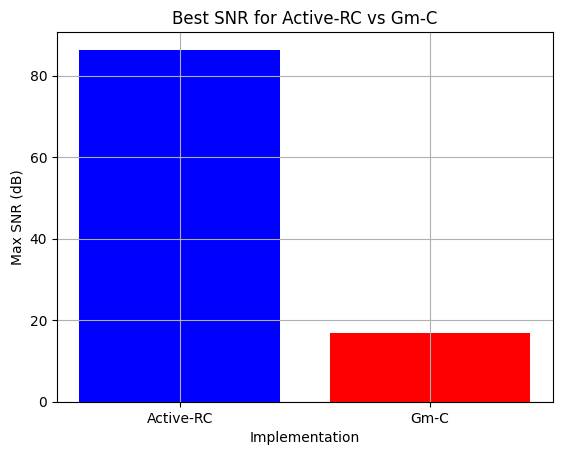

In [52]:
# plot SNR results:
plt.figure()
plt.bar(['Active-RC', 'Gm-C'], [best_snr_ActiveRC, best_snr_GmC], color=['blue', 'red'])
plt.xlabel('Implementation')
plt.ylabel('Max SNR (dB)')
plt.title('Best SNR for Active-RC vs Gm-C')
plt.grid()
plt.show()

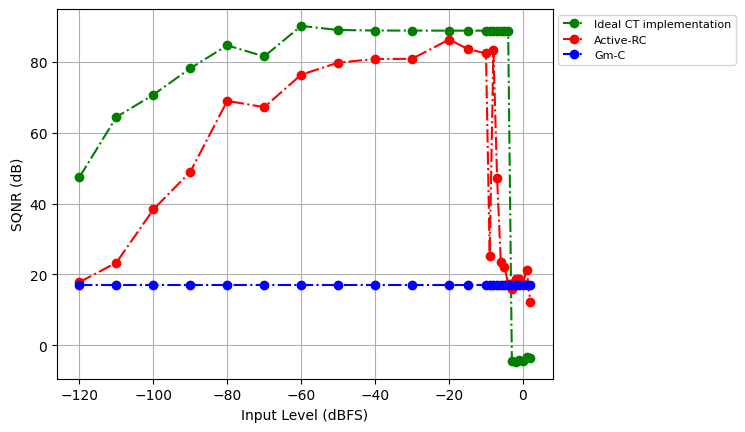

In [53]:
# plot SNR results:
plt.figure()
plt.plot(amp, snr, 'o-.g', label='Ideal CT implementation')
plt.plot(best_amp_values_ActiveRC, best_snr_values_ActiveRC, 'o-.r', label='Active-RC')
plt.plot(best_amp_values_GmC, best_snr_values_GmC, 'o-.b', label='Gm-C')
plt.xlabel('Input Level (dBFS)')
plt.ylabel('SQNR (dB)')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

There must be mistakes in the notebook, as Gm-C implementations show constant values for SNR. I have tried to fix it, but I couldn't find any solution to this error.